# IMPORTING REQUIRED LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD AND VISUALIZE DATA

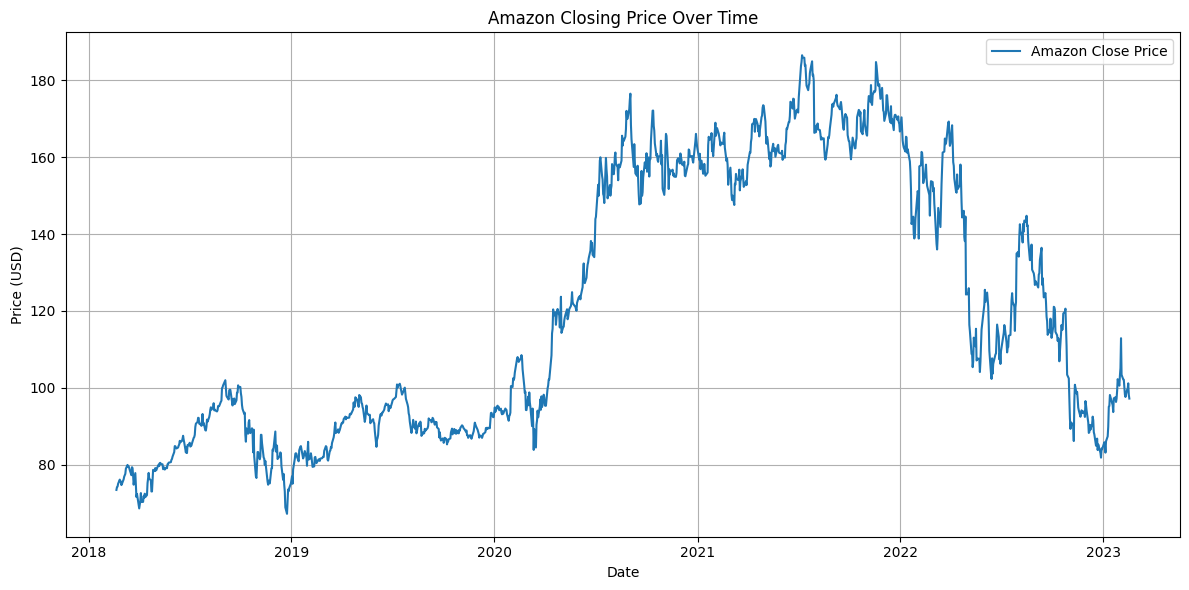

In [ ]:
# Load Amazon stock closing prices
amzn_df = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)
close_prices = amzn_df[['Close']].copy()

# Visualize closing prices
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Amazon Close Price')
plt.title('Amazon Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# STATIONARITY CHECK (ADF & KPSS TESTS)

In [ ]:
# Augmented Dickey-Fuller and KPSS tests on original series
adf_pvalue = adfuller(close_prices['Close'])[1]
kpss_pvalue = kpss(close_prices['Close'], regression='c', nlags="auto")[1]
print("ADF p-value (Original):", adf_pvalue)
print("KPSS p-value (Original):", kpss_pvalue)

# First order differencing for stationarity
diff_close = close_prices.diff().dropna()
adf_pvalue_diff = adfuller(diff_close['Close'])[1]
kpss_pvalue_diff = kpss(diff_close['Close'], regression='c', nlags="auto")[1]
print("ADF p-value (Differenced):", adf_pvalue_diff)
print("KPSS p-value (Differenced):", kpss_pvalue_diff)

ADF p-value (Original): 0.45297105465166737
KPSS p-value (Original): 0.01
ADF p-value (Differenced): 0.0
KPSS p-value (Differenced): 0.1


# AUTOCORRELATION (ACF & PACF) PLOTS

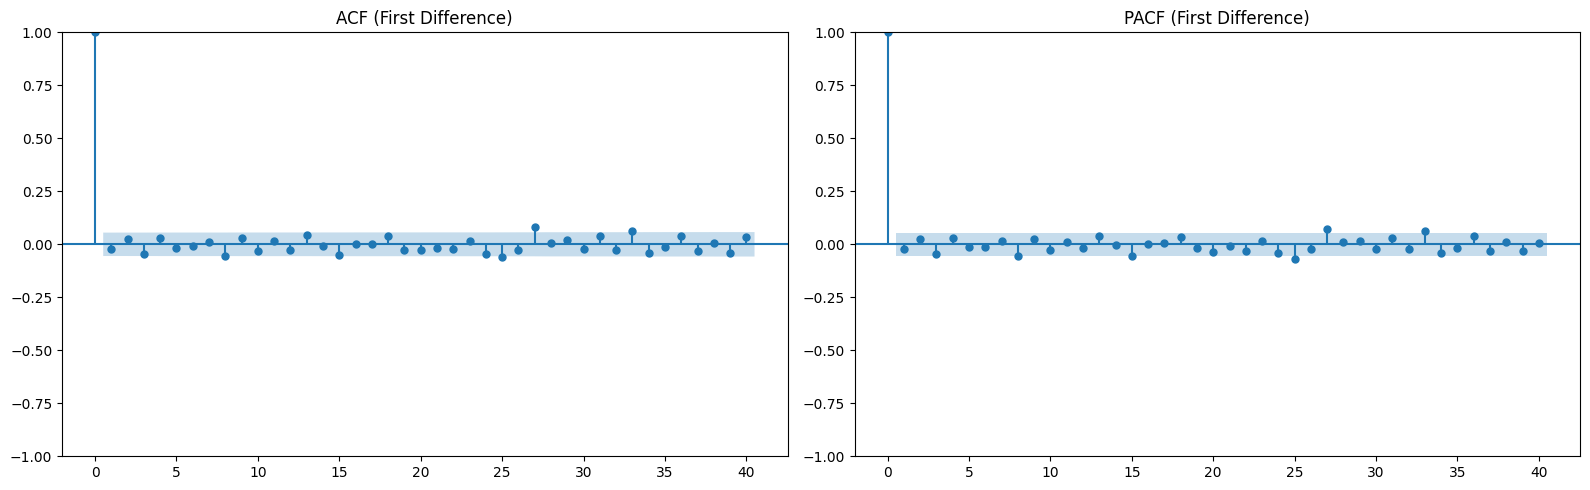

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_close, lags=40, ax=axes[0])
axes[0].set_title("ACF (First Difference)")
plot_pacf(diff_close, lags=40, ax=axes[1])
axes[1].set_title("PACF (First Difference)")
plt.tight_layout()
plt.show()

# ARIMA MODEL SELECTION AND FORECASTING

In [ ]:
# Grid search for best ARIMA(p,1,q) using AIC
lowest_aic = np.inf
optimal_order = None
best_arima_model = None
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(close_prices['Close'], order=(p, 1, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                optimal_order = (p, 1, q)
                best_arima_model = model
        except:
            continue

print("Optimal ARIMA order:", optimal_order)

# Forecasting for the next 730 days (approx. 24 months)
forecast_steps = 730
arima_forecast = best_arima_model.get_forecast(steps=forecast_steps)
forecast_mean = arima_forecast.predicted_mean
forecast_ci = arima_forecast.conf_int()
forecast_dates = pd.date_range(start=close_prices.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

Optimal ARIMA order: (2, 1, 2)


# ARIMA TRAIN/TEST SPLIT & PERFORMANCE EVALUATION

In [ ]:
test_periods = 24
train_arima = close_prices[:-test_periods]
test_arima = close_prices[-test_periods:]

# Fit ARIMA on training data
trained_arima = ARIMA(train_arima['Close'], order=optimal_order).fit()
arima_test_forecast = trained_arima.get_forecast(steps=test_periods)
arima_test_pred = arima_test_forecast.predicted_mean.values
arima_test_true = test_arima['Close'].values

# Evaluation metrics
arima_mae = mean_absolute_error(arima_test_true, arima_test_pred)
arima_rmse = np.sqrt(mean_squared_error(arima_test_true, arima_test_pred))
arima_mape = mean_absolute_percentage_error(arima_test_true, arima_test_pred)

print("ARIMA Test Set Performance (Last 24 days):")
print("MAE :", round(arima_mae, 4))
print("RMSE:", round(arima_rmse, 4))
print("MAPE:", round(arima_mape, 4))

ARIMA Test Set Performance (Last 24 days):
MAE : 2.9318
RMSE: 4.2158
MAPE: 0.0285


# PLOT ARIMA FORECAST

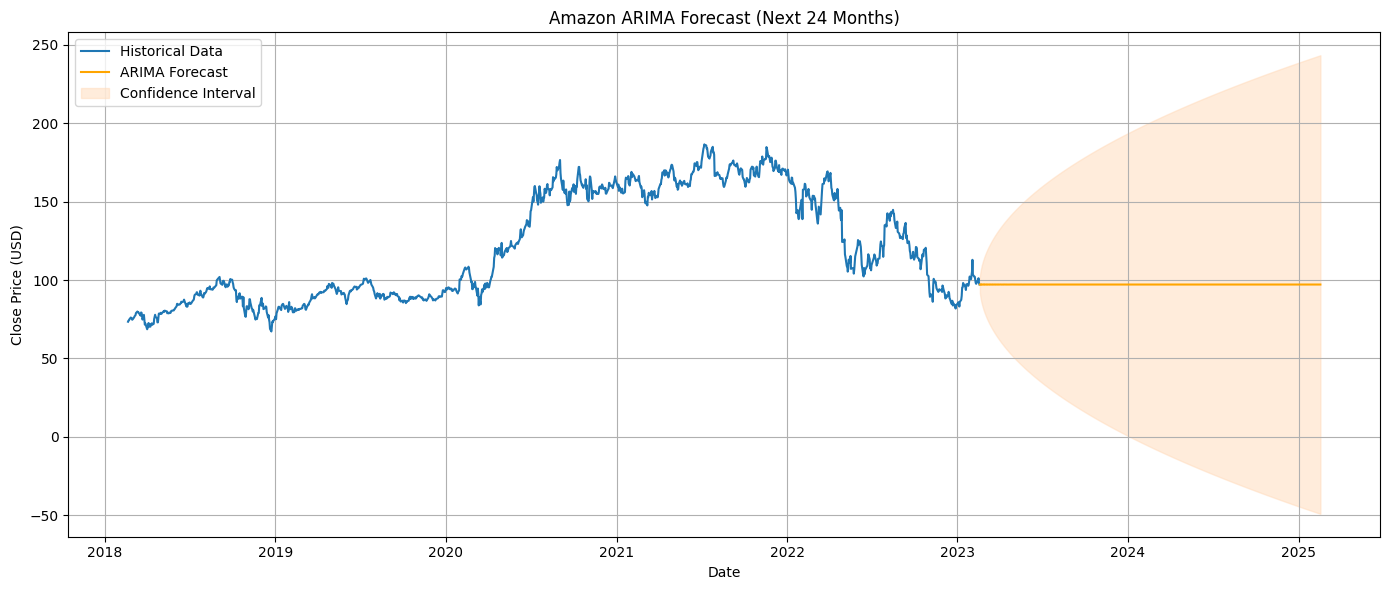

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(close_prices.index, close_prices['Close'], label='Historical Data')
plt.plot(forecast_dates, forecast_mean, label='ARIMA Forecast', color='orange')
plt.fill_between(forecast_dates,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='peachpuff', alpha=0.5, label='Confidence Interval')
plt.title('Amazon ARIMA Forecast (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# GRU DEEP LEARNING MODEL

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1182 - val_loss: 0.0042
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.0858e-04 - val_loss: 0.0018
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.6801e-04 - val_loss: 0.0018
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 7.1813e-04 - val_loss: 0.0017
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.9413e-04 - val_loss: 0.0016
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.2673e-04 - val_loss: 0.0017
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.6835e-04 - val_loss: 0.0015
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.7016e-04 - val_loss: 0.0015
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 6.3876e-04 - val_loss: 0.0014
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.9510e-04 - val_loss: 0.0015
Epoch 12/50
30/30 ━━━━━━━━━

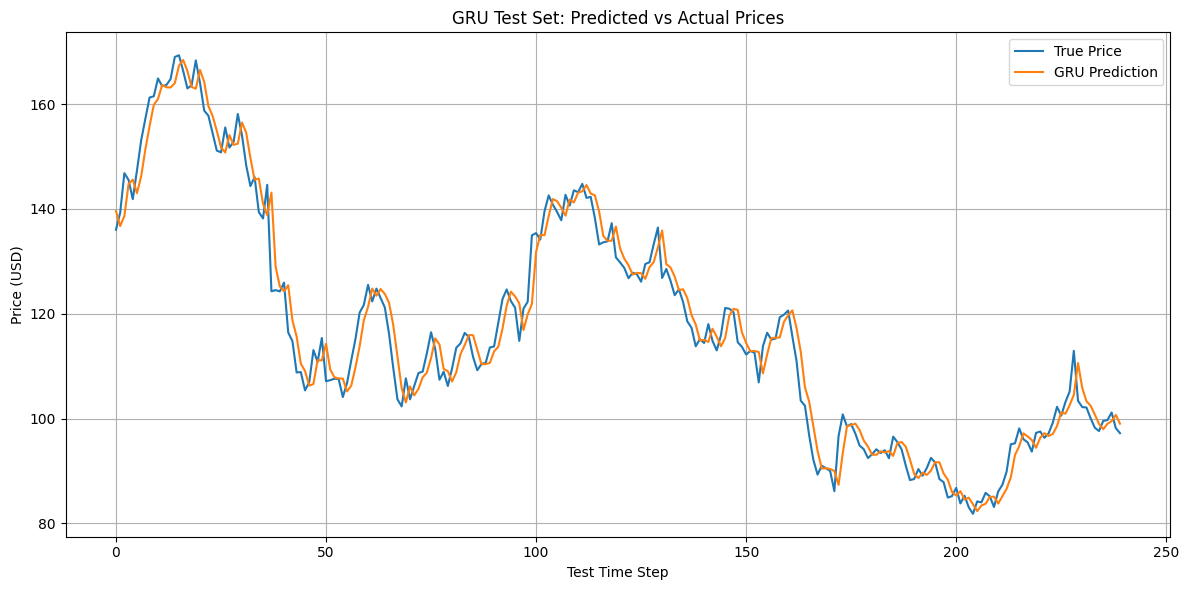

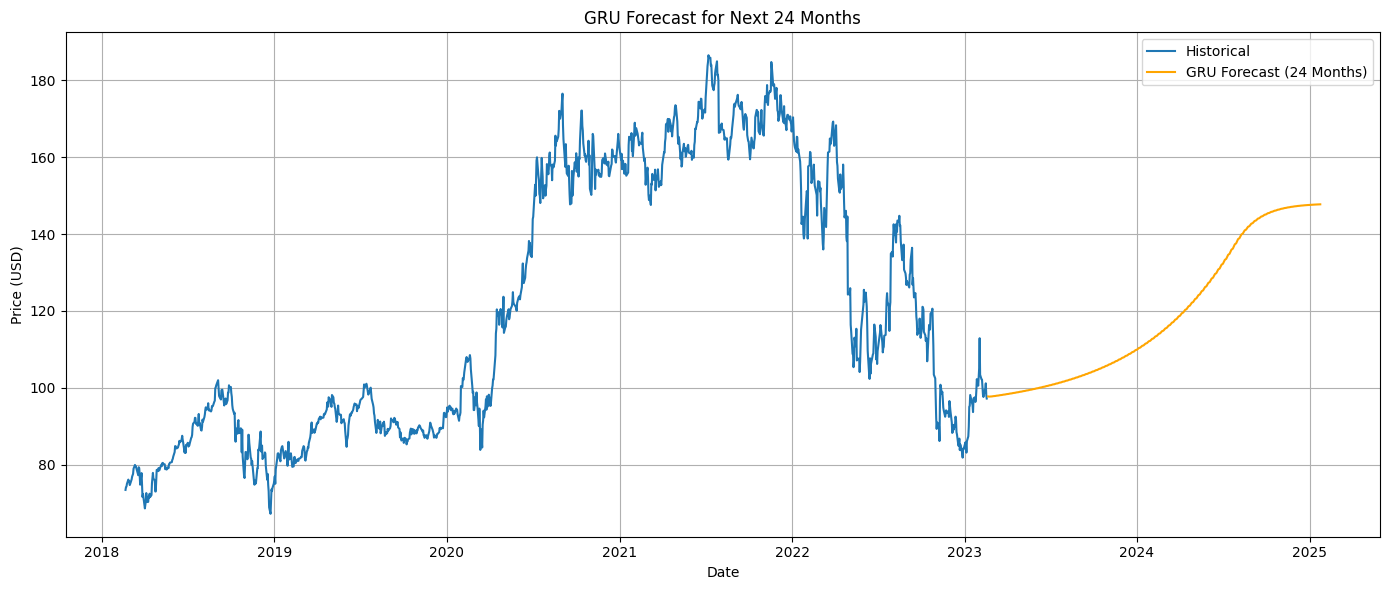

In [ ]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices[['Close']])

# Create sequences for supervised learning
def make_sequences(series, window):
    x, y = [], []
    for i in range(len(series) - window):
        x.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(x), np.array(y)

gru_seq_len = 60
X_gru, y_gru = make_sequences(scaled_close, gru_seq_len)
X_gru = X_gru.reshape(X_gru.shape[0], X_gru.shape[1], 1)

# Split into train/test
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y_gru, test_size=0.2, shuffle=False)

# Define and train GRU model
gru_model = Sequential([
    GRU(64, input_shape=(X_train_gru.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

gru_model.fit(
    X_train_gru, y_train_gru,
    validation_data=(X_test_gru, y_test_gru),
    epochs=50,
    batch_size=32,
    callbacks=[gru_earlystop],
    verbose=1
)

# GRU prediction and evaluation
y_gru_pred = gru_model.predict(X_test_gru)
y_gru_true = scaler.inverse_transform(y_test_gru.reshape(-1, 1)).flatten()
y_gru_pred_actual = scaler.inverse_transform(y_gru_pred).flatten()

gru_mae = mean_absolute_error(y_gru_true, y_gru_pred_actual)
gru_rmse = np.sqrt(mean_squared_error(y_gru_true, y_gru_pred_actual))
gru_mape = mean_absolute_percentage_error(y_gru_true, y_gru_pred_actual)

print("GRU Test Set Performance:")
print("MAE :", gru_mae)
print("RMSE:", gru_rmse)
print("MAPE:", gru_mape)

# Plot GRU predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_gru_true, label='True Price')
plt.plot(y_gru_pred_actual, label='GRU Prediction')
plt.title('GRU Test Set: Predicted vs Actual Prices')
plt.xlabel('Test Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# GRU 24-month (504 business days) future forecast
def forecast_gru_future(model, last_scaled, future_days=504, seq_len=60):
    last_seq = last_scaled[-seq_len:].reshape(1, seq_len, 1)
    future_preds = []
    for _ in range(future_days):
        pred = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

future_gru_prices = forecast_gru_future(gru_model, scaled_close, future_days=504, seq_len=60)
future_gru_dates = pd.date_range(start=close_prices.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(close_prices.index, scaler.inverse_transform(scaled_close), label='Historical')
plt.plot(future_gru_dates, future_gru_prices, label='GRU Forecast (24 Months)', color='orange')
plt.title('GRU Forecast for Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# LSTM DEEP LEARNING MODEL

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1410 - val_loss: 0.0054
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0

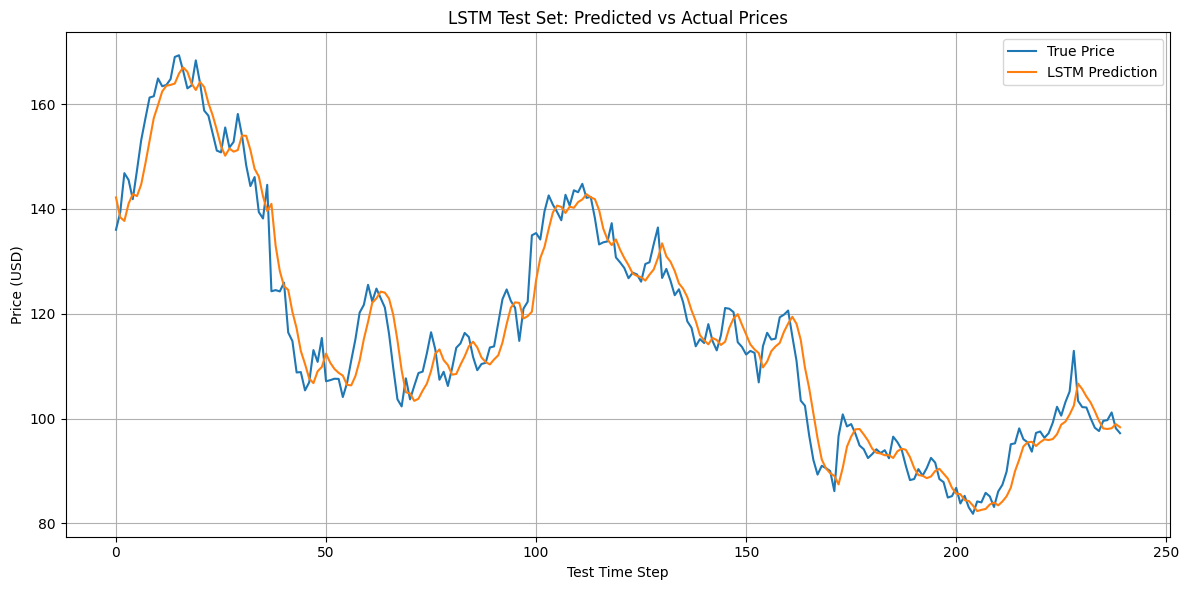

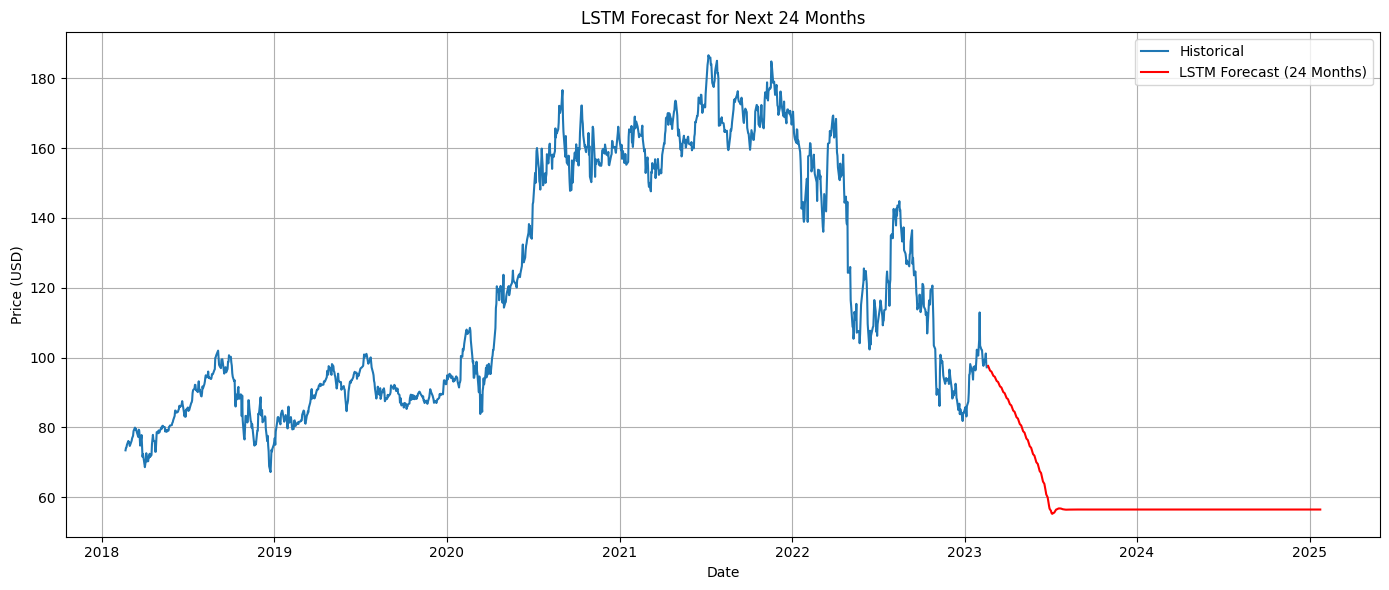

In [ ]:
# Sequences are already created, just reuse:
X_lstm, y_lstm = X_gru, y_gru  # Same as GRU setup

# Train/test split for LSTM (reuse splits for consistency)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = X_train_gru, X_test_gru, y_train_gru, y_test_gru

# Define and train LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=50,
    batch_size=32,
    callbacks=[lstm_earlystop],
    verbose=1
)

# LSTM prediction and evaluation
y_lstm_pred = lstm_model.predict(X_test_lstm)
y_lstm_true = scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
y_lstm_pred_actual = scaler.inverse_transform(y_lstm_pred).flatten()

lstm_mae = mean_absolute_error(y_lstm_true, y_lstm_pred_actual)
lstm_rmse = np.sqrt(mean_squared_error(y_lstm_true, y_lstm_pred_actual))
lstm_mape = mean_absolute_percentage_error(y_lstm_true, y_lstm_pred_actual)

print("LSTM Test Set Performance:")
print(f"MAE  : {lstm_mae:.4f}")
print(f"RMSE : {lstm_rmse:.4f}")
print(f"MAPE : {lstm_mape:.4f}")

# Plot LSTM predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_lstm_true, label='True Price')
plt.plot(y_lstm_pred_actual, label='LSTM Prediction')
plt.title('LSTM Test Set: Predicted vs Actual Prices')
plt.xlabel('Test Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM 24-month (504 business days) forecast
def forecast_lstm_future(model, last_scaled, future_days=504, seq_len=60):
    last_seq = last_scaled[-seq_len:].reshape(1, seq_len, 1)
    future_preds = []
    for _ in range(future_days):
        pred = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

future_lstm_prices = forecast_lstm_future(lstm_model, scaled_close, future_days=504, seq_len=60)
future_lstm_dates = pd.date_range(start=close_prices.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(close_prices.index, scaler.inverse_transform(scaled_close), label='Historical')
plt.plot(future_lstm_dates, future_lstm_prices, label='LSTM Forecast (24 Months)', color='red')
plt.title('LSTM Forecast for Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()